<a href="https://colab.research.google.com/github/inspire-lab/CyberAI-labs/blob/main/category-SecureAI/Evasion-defense/defend_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defense with adversarial training

In this section we will use adversarial training to harden our CNN against adversarial examples.

In adversarial training the dataset get "augmented" with adversarial examples that are correctly labeled. This way the network learns that such pertubations are possible and can adapt to them.

We will be using the IBM Adversarial Robustness Toolbox in this exercise. It offers a very easy-to-use implementation of adversarial training and a number of other defenses.
https://github.com/IBM/adversarial-robustness-toolbox


We start out by importing most of the modules and functions we will need.

In [ ]:
!pip install adversarial-robustness-toolbox

import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.metrics import empirical_robustness

In [ ]:
def extract_ones_and_zeroes(data, labels):
    data_zeroes = data[np.argwhere(labels == 0).reshape(-1)][:200]
    data_ones = data[np.argwhere(labels == 1).reshape(-1)][:200]
    x = np.vstack((data_zeroes, data_ones)) / 255.0

    labels_zeroes = np.zeros(data_zeroes.shape[0])
    labels_ones = np.ones(data_ones.shape[0])
    y = np.append(labels_zeroes, labels_ones)

    return x, y

def convert_to_keras_image_format(x_train, x_test):
    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    return x_train, x_test

def mnist_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


We start out by loading the data, preparing it and training and evaluating our CNN.

In [ ]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Extract ones and zeroes
x_train, y_train = extract_ones_and_zeroes(x_train, y_train)
x_test, y_test = extract_ones_and_zeroes(x_test, y_test)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Reshape data for CNN
x_train, x_test = convert_to_keras_image_format(x_train, x_test)
input_shape = x_train.shape[1:]

# Create and train the CNN model
clf = mnist_cnn_model(input_shape=input_shape, num_classes=2)
clf.fit(x_train, y_train, epochs=2, batch_size=100, verbose=1)

# Evaluate the model
score = clf.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step - accuracy: 0.6667 - loss: 0.5180
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.9957 - loss: 0.0484
Test loss: 0.01319551095366478
Test accuracy: 0.9925000071525574


We want to know how robust our model is against an attack. To do this we are calculating the `empirical robustness`. This is equivalent to computing the minimal perturbation that the attacker must introduce for a    successful attack. We are following the approach of Moosavi-Dezfooli et al. 2016 (paper link: https://arxiv.org/abs/1511.04599). Then, we create an adversarial example and see how it looks.

Robustness of the undefended model: 0.10004374453193354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Class prediction for the adversarial sample: 0


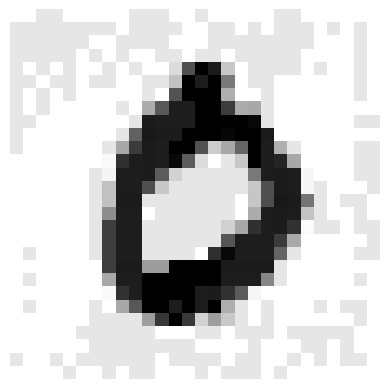

In [ ]:


from art.estimators.classification import TensorFlowV2Classifier

# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Wrap the model with TensorFlowV2Classifier
art_clf = TensorFlowV2Classifier(
    model=clf,
    clip_values=(0, 1),
    input_shape=x_test[0].shape,
    nb_classes=2,
    loss_object=loss_object
)

# Calculate empirical robustness
robustness = empirical_robustness(art_clf, x_test, attack_name="fgsm", attack_params={"eps": 0.1})
print('Robustness of the undefended model:', robustness)

# Generate adversarial example with FGSM
fgsm = FastGradientMethod(estimator=art_clf, eps=0.1)
x_adv = fgsm.generate(x=x_test[0:1])

# Display adversarial example
print('Class prediction for the adversarial sample:', np.argmax(clf.predict(x_adv)))
plt.imshow(x_adv.reshape(28, 28), cmap="gray_r")
plt.axis('off')
plt.show()

## Adversarial Training

We are getting a new untrained model with the same architecture that we have been using so far.

To use the adversarial training that comes with `art` we need to pass our wrapped model to an `AdversarialTrainer` instance. The `AdversarialTrainer` also needs an instance of the attack that will be used to create the adversarial examples.

In [ ]:
# Create an untrained model
new_model = mnist_cnn_model(input_shape=input_shape, num_classes=2)

# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Wrap the model with TensorFlowV2Classifier
art_clf_defended = TensorFlowV2Classifier(
    model=new_model,
    clip_values=(0, 1),
    input_shape=x_test[0].shape,
    nb_classes=2,
    loss_object=loss_object,
    optimizer=optimizer
)

# define the attack we are using
fgsm = FastGradientMethod(art_clf_defended)

Create the `AdversarialTrainer` instance.
Train the model and evaluate it on the test data.

In [ ]:
# Define the adversarial trainer
adversarial_trainer = AdversarialTrainer(classifier=art_clf_defended, attacks=fgsm)
adversarial_trainer.fit(x_train, y_train, batch_size=100, nb_epochs=2)


# Evaluate the defended model
score = art_clf_defended._model.evaluate(x_test, y_test, verbose=0)
print('Test loss (defended):', score[0])
print('Test accuracy (defended):', score[1])

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Test loss (defended): 0.025193100795149803
Test accuracy (defended): 0.9925000071525574


Calculate the `empirical robustness` for our now hopefully more robust model.

Robustness of the defended model: 0.10009842519685043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Class prediction for the adversarial sample: [0]


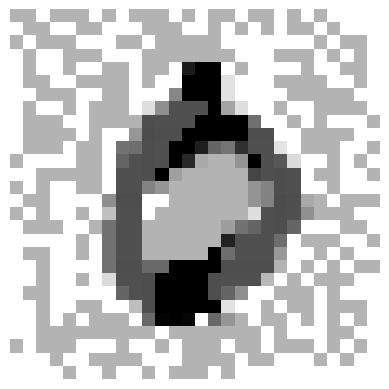

In [ ]:
# Calculate the empirical robustness of the defended model
robustness = empirical_robustness(art_clf_defended, x_test, attack_name="fgsm", attack_params={"eps": 0.1})
print('Robustness of the defended model:', robustness)

# Generate an adversarial sample
x_adv = fgsm.generate(x=x_test[0:1])  # Generate adversarial example for the first test sample

# Display the adversarial sample
print('Class prediction for the adversarial sample:', np.argmax(art_clf_defended._model.predict(x_adv), axis=1))
plt.imshow(x_adv.reshape(28, 28), cmap="gray_r")
plt.axis('off')
plt.show()